# Multi Armed Bandits

## EX 2.3

In [1]:
import numpy as np
from scipy.stats import norm

In [128]:
def long_term_probability(k: int, eps: float) -> float:
    return 1 - eps * (1 - 1 / k)

In [6]:
def estimate_q_star_mean(k: int) -> float:
    x = np.arange(start=-30, stop=30, step=0.001)

    pdfs = norm.pdf(x)
    cdfs = np.power(norm.cdf(x), k - 1)

    integrand = k * x * cdfs * pdfs

    return np.trapezoid(integrand, x)

In [11]:
estimate_q_star_mean(10)

np.float64(1.538752730835173)

In [12]:
def estimate_expected_return(k: int, eps: float) -> float:
    return (1 - eps) * estimate_q_star_mean(k)

In [14]:
expected_return = estimate_expected_return(k=10, eps=0.01)
expected_prob = long_term_probability(k=10, eps=0.01)

print(f"{expected_return=:.4f}; {expected_prob=:.4f}")

expected_return=1.5234; expected_prob=0.9910


In [15]:
expected_return = estimate_expected_return(k=10, eps=0.1)
expected_prob = long_term_probability(k=10, eps=0.1)

print(f"{expected_return=:.4f}; {expected_prob=:.4f}")

expected_return=1.3849; expected_prob=0.9100


In [16]:
factor = (1 - 0.01) / (1 - 0.1)
print(f"{factor=}")

factor=1.0999999999999999


In [17]:
1.5234 / 1.3849

1.1000072207379594

## Replicating Stationary Experiment Learning Curves
We plot the following experiments ($N = 2000$ runs per experiment, $T = 1000$ steps):
1. Greedy
2. $\epsilon=0.01$-greedy 
3. $\epsilon=0.1$-greedy 
4. Initial Optimistic Value greedy $Q_1(a) = 5$
5. UCB $c=2$
6. Performance Gradient $\alpha=0.1$

We plot the average reward and % optimal value.

In [2]:
from multi_armed_bandits.experiment_config import ExperimentConfig
from multi_armed_bandits.bandit_algorithm_config import (
    BanditAlgorithmConfig,
    SampleAverageActionValueEpsilonGreedyConfig,
    ExponentialRecencyWeightedAverageActionValueEpsilonGreedyConfig,
    UpperConfidenceBoundGreedyConfig,
    PerformanceGradientConfig,
)
from multi_armed_bandits.run_experiment import run_experiment, run_experiment_for_average_reward
from concurrent.futures import ProcessPoolExecutor, as_completed, Future
from typing import Dict, List, Any
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import time
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

In [3]:
def run_simulation(expt_config: ExperimentConfig, num_simulations: int, num_workers: int = 1) -> Dict[str, np.ndarray]:
    """
    Run simulation for a given experiment `num_simulations` time. Report the mean metric (reward, is_optimal).
    """

    # list of metrics that we will aggregate
    aggregate_metrics = defaultdict(list)

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(run_experiment, expt_config) for _ in range(num_simulations)]

        for future in as_completed(futures):
            result = future.result()

            for result_key, result_value in result.items():
                aggregate_metrics[result_key].append(result_value)
    
    # take mean of the aggregate metrics
    for agg_key, agg_value in aggregate_metrics.items():
        aggregate_metrics[agg_key] = np.mean(np.array(agg_value), axis=0)
    
    return aggregate_metrics


In [44]:
# base setup for all exoeriments
base_experiment_config = ExperimentConfig(
    name="base",
    is_stationary=True,
    random_walk_std=None,
    k=10,
    num_time_steps=1000,
    aggregation_time_steps=None,
    bandit_algorithm_config=BanditAlgorithmConfig(),  # have to override
)

In [4]:
def override_base_experiment_config(base_experiment_config: ExperimentConfig, name: str, algo_config: BanditAlgorithmConfig) -> ExperimentConfig:
    config = deepcopy(base_experiment_config)
    config.name = name
    config.bandit_algorithm_config = algo_config
    return config

In [5]:
# create algo configs for experiments
greedy_algo_config = SampleAverageActionValueEpsilonGreedyConfig(epsilon=0)
eps_001_algo_config = SampleAverageActionValueEpsilonGreedyConfig(epsilon=0.01)
eps_01_algo_config = SampleAverageActionValueEpsilonGreedyConfig(epsilon=0.1)
optimistic_initial_value_config = ExponentialRecencyWeightedAverageActionValueEpsilonGreedyConfig(
    epsilon=0.0,
    step_size=0.1,
    initial_action_value=5.0,
)
ucb_config = UpperConfidenceBoundGreedyConfig(confidence=2.0)
perf_gradient_config = PerformanceGradientConfig(step_size=0.1)

In [47]:
# create experiment configs for each
name_config_pairs = [
    ("greedy", greedy_algo_config),
    ("$\epsilon=0.01$", eps_001_algo_config),
    ("$\epsilon=0.1$", eps_01_algo_config),
    ("optimistic", optimistic_initial_value_config),
    ("UCB", ucb_config),
    ("performance gradient", perf_gradient_config),
]

experiment_configs = {
    name: override_base_experiment_config(base_experiment_config, name=name, algo_config=config) for name, config in name_config_pairs
}

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_89739/133722798.py:4: SyntaxWarning: invalid escape sequence '\e'
  ("$\epsilon=0.01$", eps_001_algo_config),
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_89739/133722798.py:5: SyntaxWarning: invalid escape sequence '\e'
  ("$\epsilon=0.1$", eps_01_algo_config),


In [ ]:
# run simulation for each, store results in a map from name to results dict
results = dict()

for expt_config in experiment_configs.values():
    print(f"Running simulation for {expt_config.name=}")

    start_time = time.time()
    expt_result = run_simulation(expt_config=expt_config, num_simulations=2000, num_workers=8)

    duration = time.time() - start_time
    print(f"Finished running simulation for {expt_config.name=} in {duration=:.2f} seconds")

    results[expt_config.name] = expt_result

Running simulation for expt_config.name='greedy'


Finished running simulation for expt_config.name='greedy' in duration=3.3 seconds
Running simulation for expt_config.name='$\\epsilon=0.01$'
Finished running simulation for expt_config.name='$\\epsilon=0.01$' in duration=3.1 seconds
Running simulation for expt_config.name='$\\epsilon=0.1$'
Finished running simulation for expt_config.name='$\\epsilon=0.1$' in duration=3.2 seconds
Running simulation for expt_config.name='optimistic'
Finished running simulation for expt_config.name='optimistic' in duration=3.2 seconds
Running simulation for expt_config.name='UCB'
Finished running simulation for expt_config.name='UCB' in duration=4.4 seconds
Running simulation for expt_config.name='performance gradient'
Finished running simulation for expt_config.name='performance gradient' in duration=6.6 seconds


In [53]:
color_mappings = {
    "greedy": "g",
    "$\epsilon=0.01$": "r",
    "$\epsilon=0.1$": "b",
    "optimistic": "orange",
    "UCB": "gray",
    "performance gradient": "purple",
}

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_89739/2502009177.py:3: SyntaxWarning: invalid escape sequence '\e'
  "$\epsilon=0.01$": "r",
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_89739/2502009177.py:4: SyntaxWarning: invalid escape sequence '\e'
  "$\epsilon=0.1$": "b",


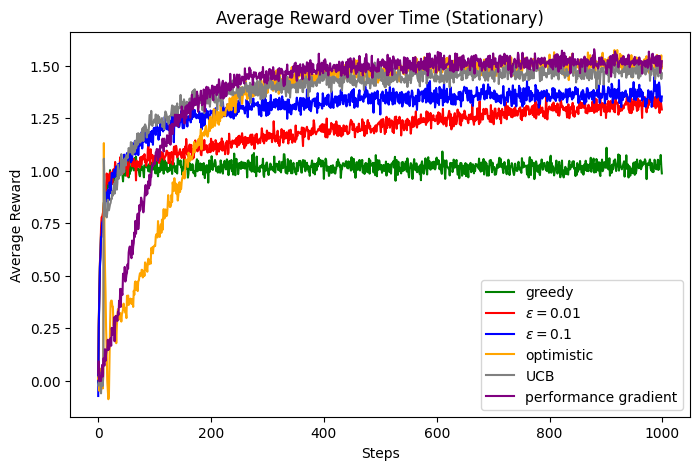

In [54]:
# plot the average reward first
fig = plt.figure(figsize=(8, 5))

plt.title("Average Reward over Time (Stationary)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")

times = np.arange(results["greedy"]["reward"].shape[0])

for color_mapping_key, color in color_mappings.items():
    plt.plot(times, results[color_mapping_key]["reward"], label=color_mapping_key, c=color)
plt.legend()

plt.show()

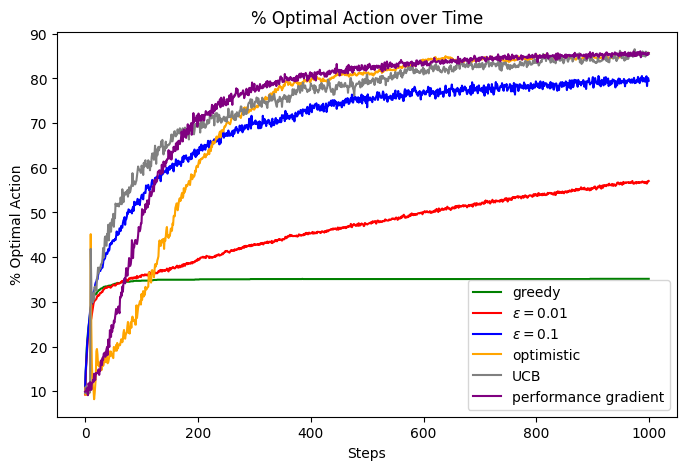

In [ ]:
# plot the % Optimal Action
fig = plt.figure(figsize=(8, 5))

plt.title("% Optimal Action over Time (Stationary)")
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")

times = np.arange(results["greedy"]["is_optimal"].shape[0])

for color_mapping_key, color in color_mappings.items():
    plt.plot(times, results[color_mapping_key]["is_optimal"] * 100, label=color_mapping_key, c=color)
plt.legend()

plt.show()

## EX 2.5: Nonstationary Experiments
We plot the following experiments ($N = 2000$ runs per experiment, $T = 10000$ steps):
1. Sample Average $\epsilon=0.1$
2. ERWA $\alpha=0.1$
3. Performance Gradient $\alpha=0.1$

We plot the average reward and % optimal value.

In [15]:
# base setup for all exoeriments
base_experiment_config = ExperimentConfig(
    name="base",
    is_stationary=False,
    random_walk_std=0.01,
    k=10,
    num_time_steps=10000,
    aggregation_time_steps=None,
    bandit_algorithm_config=BanditAlgorithmConfig(),  # have to override
)

In [16]:
# algo config for erwa
erwa_config = ExponentialRecencyWeightedAverageActionValueEpsilonGreedyConfig(
    epsilon=0.1,
    step_size=0.1,
    initial_action_value=0.0,
)

In [17]:
# prepare experiment configs
name_config_pairs = [
    ("$\epsilon=0.1$", eps_01_algo_config),
    ("exponential recency weighted avg", erwa_config),
    ("performance gradient", perf_gradient_config),
]

experiment_configs = {
    name: override_base_experiment_config(base_experiment_config, name=name, algo_config=config) for name, config in name_config_pairs
}

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_15537/1648493217.py:3: SyntaxWarning: invalid escape sequence '\e'
  ("$\epsilon=0.1$", eps_01_algo_config),


In [18]:
# run simulation for each, store results in a map from name to results dict
results = dict()

for expt_config in experiment_configs.values():
    print(f"Running simulation for {expt_config.name=}")

    start_time = time.time()
    expt_result = run_simulation(expt_config=expt_config, num_simulations=2000, num_workers=8)

    duration = time.time() - start_time
    print(f"Finished running simulation for {expt_config.name=} in {duration=:.2f} seconds")

    results[expt_config.name] = expt_result

Running simulation for expt_config.name='$\\epsilon=0.1$'
Finished running simulation for expt_config.name='$\\epsilon=0.1$' in duration=41.67 seconds
Running simulation for expt_config.name='exponential recency weighted avg'
Finished running simulation for expt_config.name='exponential recency weighted avg' in duration=42.39 seconds
Running simulation for expt_config.name='performance gradient'
Finished running simulation for expt_config.name='performance gradient' in duration=81.49 seconds


In [19]:
color_mappings = {
    "$\epsilon=0.1$": "b",
    "exponential recency weighted avg": "r",
    "performance gradient": "purple",
}

<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_15537/3860063096.py:2: SyntaxWarning: invalid escape sequence '\e'
  "$\epsilon=0.1$": "b",


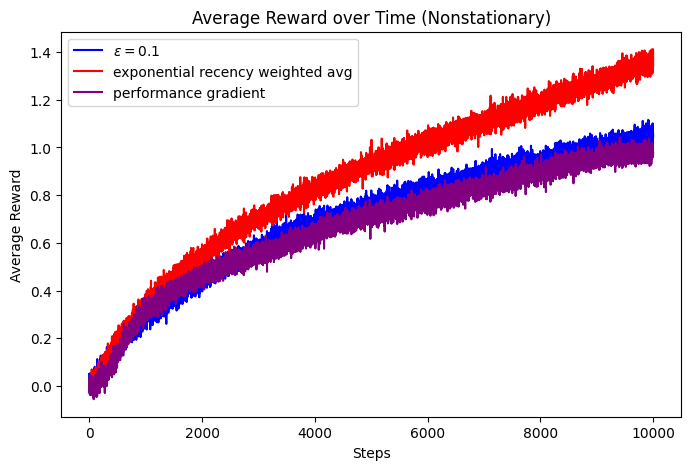

In [20]:
# plot the average reward first
fig = plt.figure(figsize=(8, 5))

plt.title("Average Reward over Time (Nonstationary)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")

times = np.arange(results["performance gradient"]["reward"].shape[0])

for color_mapping_key, color in color_mappings.items():
    plt.plot(times, results[color_mapping_key]["reward"], label=color_mapping_key, c=color)
plt.legend()

plt.show()

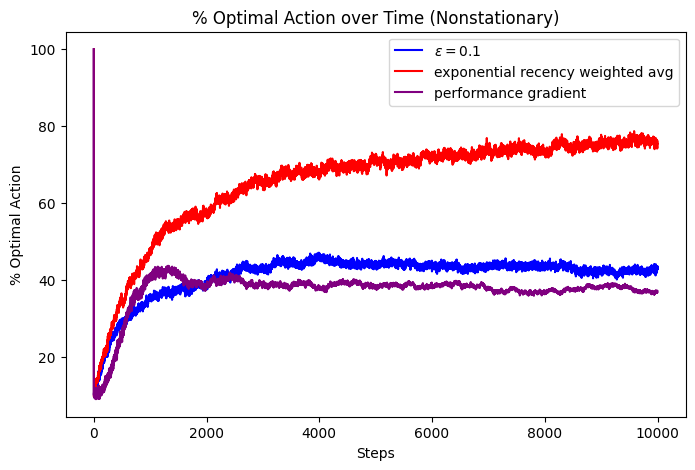

In [21]:
# plot the % Optimal Action
fig = plt.figure(figsize=(8, 5))

plt.title("% Optimal Action over Time (Nonstationary)")
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")

times = np.arange(results["performance gradient"]["is_optimal"].shape[0])

for color_mapping_key, color in color_mappings.items():
    plt.plot(times, results[color_mapping_key]["is_optimal"] * 100, label=color_mapping_key, c=color)
plt.legend()

plt.show()

## EX 2.11: Parameter Study and Comparison of Multi Bandit Algorithms

We replicate the results in the book but with error bars. Run each algorithm for $T = 200000$ steps, take the average return of the last $100000$ steps. Run experiments $N = 2000$ times, and compute the mean and SE. We plot these with error bars.

We run algorithms for stationary and nonstationary via multiprocessing (one experiment per process). The main process will be in charge of cataloging results then aggregating (light work).

### Stationary Experiments

In [47]:
import pandas as pd
from dataclasses import dataclass

In [48]:
@dataclass
class HyperparameterGridSpec:
    """
    Spec for a hyperparameter grid search. Name is the name of the parameter, and we search for
    [2**exp for exp in range((lower_exp_bound, upper_exp_bound + 1)] (inclusive)
    """
    name: str
    lower_exp_bound: int
    upper_exp_bound: int

In [49]:
# map from algo type to name of the hyperparameter name and bound (in form of 2**exp)

HYPERPAREMTER_SEARCH_GRID = {
    "$\epsilon$-greedy": HyperparameterGridSpec(name="epsilon", lower_exp_bound=-7, upper_exp_bound=-2),
    "gradient bandit": HyperparameterGridSpec(name="alpha", lower_exp_bound=-5, upper_exp_bound=1),
    "UCB": HyperparameterGridSpec(name="c", lower_exp_bound=-4, upper_exp_bound=2),
    "optimistic init greedy": HyperparameterGridSpec(name="Q_0", lower_exp_bound=-2, upper_exp_bound=2),
}

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/3109112018.py:4: SyntaxWarning: invalid escape sequence '\e'
  "$\epsilon$-greedy": HyperparameterGridSpec(name="epsilon", lower_exp_bound=-7, upper_exp_bound=-2),


In [50]:
@dataclass
class AlgorithmConfigHyperparameterEntry:
    hyperparameter_name: str
    hyperparameter_value_exp: int
    config: BanditAlgorithmConfig


@dataclass
class ExperimentConfigHyperparameterEntry:
    hyperparameter_name: str
    hyperparameter_value_exp: int
    config: ExperimentConfig

In [51]:
# map from algo name to an initializer for the algo config
algo_config_initializers = {
    "$\epsilon$-greedy": lambda param: SampleAverageActionValueEpsilonGreedyConfig(epsilon=param),
    "gradient bandit": lambda param: PerformanceGradientConfig(step_size=param),
    "UCB": lambda param: UpperConfidenceBoundGreedyConfig(confidence=param),
    "optimistic init greedy": lambda param: ExponentialRecencyWeightedAverageActionValueEpsilonGreedyConfig(epsilon=0.0, step_size=0.1, initial_action_value=param),
}

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/244968464.py:3: SyntaxWarning: invalid escape sequence '\e'
  "$\epsilon$-greedy": lambda param: SampleAverageActionValueEpsilonGreedyConfig(epsilon=param),


In [52]:
# create mapping from name -> AlgorithmConfigHyperparameterEntry
algorithm_config_hyperparameter_entries: Dict[str, AlgorithmConfigHyperparameterEntry] = dict()

for algo_name, algo_initializer in algo_config_initializers.items():
    hyperparameter_grid_spec = HYPERPAREMTER_SEARCH_GRID[algo_name]

    algorithm_config_hyperparameter_entries[algo_name] = [
        AlgorithmConfigHyperparameterEntry(
            hyperparameter_name=hyperparameter_grid_spec.name,
            hyperparameter_value_exp=value_exp,
            config=algo_initializer(2**value_exp),
        )
        for value_exp in range(hyperparameter_grid_spec.lower_exp_bound, hyperparameter_grid_spec.upper_exp_bound + 1)
    ]

In [53]:
# base experiment config - we will override the name algorithm config
BASE_EXPERIMENT_CONFIG = ExperimentConfig(
    name="base",
    is_stationary=True,
    random_walk_std=None,
    k=10,
    num_time_steps=1000,
    aggregation_time_steps=1000,
    bandit_algorithm_config=BanditAlgorithmConfig(),
)

In [54]:
def override_base_config(base_config: ExperimentConfig, name: str, algo_config: BanditAlgorithmConfig) -> ExperimentConfig:
    config = deepcopy(base_config)
    config.name = name
    config.bandit_algorithm_config = algo_config

    return config

In [55]:
# create list of ExperimentConfigExperimentEntry
experiment_config_entries = []

for algo_name, algo_config_entry_list in algorithm_config_hyperparameter_entries.items():
    for algo_config_entry in algo_config_entry_list:
        experiment_config_entries.append(ExperimentConfigHyperparameterEntry(
            hyperparameter_name=algo_config_entry.hyperparameter_name,
            hyperparameter_value_exp=algo_config_entry.hyperparameter_value_exp,
            config=override_base_config(base_config=BASE_EXPERIMENT_CONFIG, name=algo_name, algo_config=algo_config_entry.config),
        ))

In [56]:
# number of times to run each experiment
N_TRIALS = 2000

In [57]:
# number of total experiments
num_total_experiments = len(experiment_config_entries) * N_TRIALS
print(f"Total number of experiments: {num_total_experiments=}")

Total number of experiments: num_total_experiments=50000


In [58]:
def run_avg_return_experiments(
        experiment_config_hyperparameter_entries: List[ExperimentConfigHyperparameterEntry], 
        num_trials: int, 
        num_workers: int = 1) -> pd.DataFrame:
    
    # rows for each result in the final dataframe
    result_rows: List[Dict[str, Any]] = []

    with tqdm(total=num_total_experiments) as pbar:
        with ProcessPoolExecutor(max_workers=num_workers) as executor:
            # iterate through the experiments, submit N_TRIALS for each; maintain map from future to the entry for later logging
            futures_map: Dict[Future, ExperimentConfigHyperparameterEntry] = dict()
            for experiment_config_hyperparameter_entry in experiment_config_hyperparameter_entries:
                for _ in range(num_trials):
                    future = executor.submit(run_experiment_for_average_reward, experiment_config_hyperparameter_entry.config)
                    futures_map[future] = experiment_config_hyperparameter_entry
            
            for future in as_completed(futures_map.keys()):
                # single float representing average reward
                avg_reward = future.result()

                metadata = futures_map[future]

                # create record in result rows
                result_rows.append({
                    "algo_name": metadata.config.name,
                    "hyperparameter_name": metadata.hyperparameter_name,
                    "hyperparameter_value_exp": metadata.hyperparameter_value_exp,
                    "avg_reward": avg_reward,
                })

                pbar.update(1)
    
    return pd.DataFrame(result_rows)
            

In [59]:
# Run experiments!
result_df = run_avg_return_experiments(experiment_config_entries, num_trials=N_TRIALS, num_workers=8)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [60]:
result_df.head()

,algo_name,hyperparameter_name,hyperparameter_value_exp,avg_reward
0,$\epsilon$-greedy,epsilon,-7,0.909067
1,$\epsilon$-greedy,epsilon,-7,1.099708
2,$\epsilon$-greedy,epsilon,-7,1.472319
3,$\epsilon$-greedy,epsilon,-7,1.293290
4,$\epsilon$-greedy,epsilon,-7,1.241426


In [61]:
# group by columns and compute the mean_avg_reward and standard_error
result_stats = result_df.groupby(by=["algo_name", "hyperparameter_name", "hyperparameter_value_exp"]).agg(
    mean=("avg_reward", "mean"),
    standard_error=("avg_reward", "sem"),
).reset_index()

In [62]:
result_stats.head(4)

,algo_name,hyperparameter_name,hyperparameter_value_exp,mean,standard_error
0,$\epsilon$-greedy,epsilon,-7,1.171611,0.013252
1,$\epsilon$-greedy,epsilon,-6,1.261426,0.013034
2,$\epsilon$-greedy,epsilon,-5,1.295096,0.012642
3,$\epsilon$-greedy,epsilon,-4,1.307971,0.012387


In [63]:
len(result_stats)

25

In [64]:
result_stats["hyperparameter_name"].unique()

array(['epsilon', 'c', 'alpha', 'Q_0'], dtype=object)

In [65]:
# configurations for plotting
COLOR_MAP = {
    "$\epsilon$-greedy": "red",
    "gradient bandit": "green",
    "UCB": "blue",
    "optimistic init greedy": "black",
}

# List of xtick hyperparameter names
DISPLAY_NAMES = [
    "$\epsilon$",
    "$c$",
    "$\\alpha$",
    "$Q_0$",
]

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/2647703137.py:3: SyntaxWarning: invalid escape sequence '\e'
  "$\epsilon$-greedy": "red",
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/2647703137.py:11: SyntaxWarning: invalid escape sequence '\e'
  "$\epsilon$",


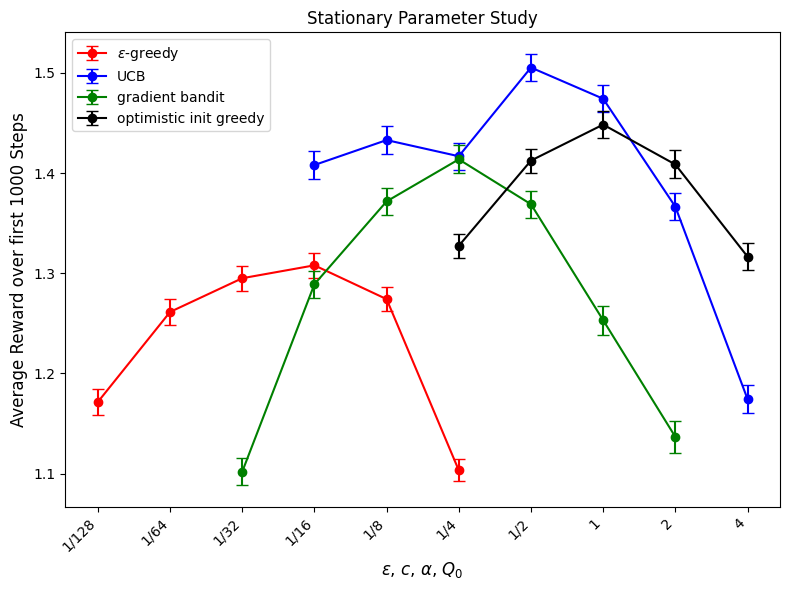

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))

# Unique algos for legend and colors
algos = result_stats['algo_name'].unique()

# Plot each algo separately
for algo in algos:
    subdf = result_stats[result_stats['algo_name'] == algo]
    x = subdf['hyperparameter_value_exp']
    y = subdf['mean']
    yerr = subdf['standard_error']
    
    ax.errorbar(
        x, y, yerr=yerr,
        label=algo,
        color=COLOR_MAP[algo],
        fmt='o-', capsize=4
    )

# Set x-axis ticks as powers of two from 2^-7 to 2^2
tick_exps = np.arange(-7, 3)
tick_labels = [f"1/{2**-exp}" if exp < 0 else f"{2**exp}" for exp in tick_exps]
ax.set_xticks(tick_exps)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

# Compose xlabel with hyperparameter names, colored by algo_name
xlabel_text = ", ".join(DISPLAY_NAMES)

ax.set_xlabel(xlabel_text, fontsize=12)
ax.set_ylabel("Average Reward over first 1000 Steps", fontsize=12)

ax.legend()

plt.title("Stationary Parameter Study")

plt.tight_layout()
plt.show()

### Nonstationary Experiments

Experiments for nonstationary setting now.

In [67]:
# map from algo name to an initializer for the algo config
algo_config_initializers = {
    "sample average $\epsilon$-greedy": lambda param: SampleAverageActionValueEpsilonGreedyConfig(epsilon=param),
    "gradient bandit": lambda param: PerformanceGradientConfig(step_size=param),
    "UCB": lambda param: UpperConfidenceBoundGreedyConfig(confidence=param),
    "optimistic init greedy": lambda param: ExponentialRecencyWeightedAverageActionValueEpsilonGreedyConfig(epsilon=0.0, step_size=0.1, initial_action_value=param),
    "ERWA $\epsilon$-greedy": lambda param: ExponentialRecencyWeightedAverageActionValueEpsilonGreedyConfig(epsilon=param, step_size=0.1, initial_action_value=0.0),
}

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/3619387623.py:3: SyntaxWarning: invalid escape sequence '\e'
  "sample average $\epsilon$-greedy": lambda param: SampleAverageActionValueEpsilonGreedyConfig(epsilon=param),
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/3619387623.py:7: SyntaxWarning: invalid escape sequence '\e'
  "ERWA $\epsilon$-greedy": lambda param: ExponentialRecencyWeightedAverageActionValueEpsilonGreedyConfig(epsilon=param, step_size=0.1, initial_action_value=0.0),


In [69]:
HYPERPAREMTER_SEARCH_GRID = {
    "sample average $\epsilon$-greedy": HyperparameterGridSpec(name="epsilon", lower_exp_bound=-7, upper_exp_bound=-2),
    "gradient bandit": HyperparameterGridSpec(name="alpha", lower_exp_bound=-5, upper_exp_bound=1),
    "UCB": HyperparameterGridSpec(name="c", lower_exp_bound=-4, upper_exp_bound=2),
    "optimistic init greedy": HyperparameterGridSpec(name="Q_0", lower_exp_bound=-2, upper_exp_bound=2),
    "ERWA $\epsilon$-greedy": HyperparameterGridSpec(name="epsilon", lower_exp_bound=-7, upper_exp_bound=2),
}

<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/3127535657.py:2: SyntaxWarning: invalid escape sequence '\e'
  "sample average $\epsilon$-greedy": HyperparameterGridSpec(name="epsilon", lower_exp_bound=-7, upper_exp_bound=-2),
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/3127535657.py:6: SyntaxWarning: invalid escape sequence '\e'
  "ERWA $\epsilon$-greedy": HyperparameterGridSpec(name="epsilon", lower_exp_bound=-7, upper_exp_bound=2),


In [70]:
# create mapping from name -> AlgorithmConfigHyperparameterEntry
algorithm_config_hyperparameter_entries: Dict[str, AlgorithmConfigHyperparameterEntry] = dict()

for algo_name, algo_initializer in algo_config_initializers.items():
    hyperparameter_grid_spec = HYPERPAREMTER_SEARCH_GRID[algo_name]

    algorithm_config_hyperparameter_entries[algo_name] = [
        AlgorithmConfigHyperparameterEntry(
            hyperparameter_name=hyperparameter_grid_spec.name,
            hyperparameter_value_exp=value_exp,
            config=algo_initializer(2**value_exp),
        )
        for value_exp in range(hyperparameter_grid_spec.lower_exp_bound, hyperparameter_grid_spec.upper_exp_bound + 1)
    ]

In [71]:
# base experiment config - we will override the name algorithm config
BASE_EXPERIMENT_CONFIG = ExperimentConfig(
    name="base",
    is_stationary=False,
    random_walk_std=0.01,
    k=10,
    num_time_steps=200000,
    aggregation_time_steps=100000,
    bandit_algorithm_config=BanditAlgorithmConfig(),
)

In [72]:
# create list of ExperimentConfigExperimentEntry
experiment_config_entries = []

for algo_name, algo_config_entry_list in algorithm_config_hyperparameter_entries.items():
    for algo_config_entry in algo_config_entry_list:
        experiment_config_entries.append(ExperimentConfigHyperparameterEntry(
            hyperparameter_name=algo_config_entry.hyperparameter_name,
            hyperparameter_value_exp=algo_config_entry.hyperparameter_value_exp,
            config=override_base_config(base_config=BASE_EXPERIMENT_CONFIG, name=algo_name, algo_config=algo_config_entry.config),
        ))

In [73]:
# number of total experiments
num_total_experiments = len(experiment_config_entries) * N_TRIALS
print(f"Total number of experiments: {num_total_experiments=}")

Total number of experiments: num_total_experiments=70000


In [75]:
# Run experiments!
result_df = run_avg_return_experiments(experiment_config_entries, num_trials=N_TRIALS, num_workers=10)  # slightly more than number of cores for scheduling

  0%|          | 0/70000 [00:00<?, ?it/s]

In [76]:
# Dump the df to disk
FNAME = "multi_bandit_nonstationary_experiment_results.csv"
result_df.to_csv(FNAME, index=False, header=True)

In [77]:
# group by columns and compute the mean_avg_reward and standard_error
result_stats = result_df.groupby(by=["algo_name", "hyperparameter_name", "hyperparameter_value_exp"]).agg(
    mean=("avg_reward", "mean"),
    standard_error=("avg_reward", "sem"),
).reset_index()

In [78]:
result_stats["algo_name"].unique()

array(['ERWA $\\epsilon$-greedy', 'UCB', 'gradient bandit',
       'optimistic init greedy', 'sample average $\\epsilon$-greedy'],
      dtype=object)

In [79]:
# configurations for plotting
COLOR_MAP = {
    "sample average $\epsilon$-greedy": "red",
    "gradient bandit": "green",
    "UCB": "blue",
    "optimistic init greedy": "black",
    "ERWA $\epsilon$-greedy": "purple",
}

# List of xtick hyperparameter names
DISPLAY_NAMES = [
    "$\epsilon$",
    "$c$",
    "$\\alpha$",
    "$Q_0$",
]

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/1351284305.py:3: SyntaxWarning: invalid escape sequence '\e'
  "sample average $\epsilon$-greedy": "red",
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/1351284305.py:7: SyntaxWarning: invalid escape sequence '\e'
  "ERWA $\epsilon$-greedy": "purple",
/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_35118/1351284305.py:12: SyntaxWarning: invalid escape sequence '\e'
  "$\epsilon$",


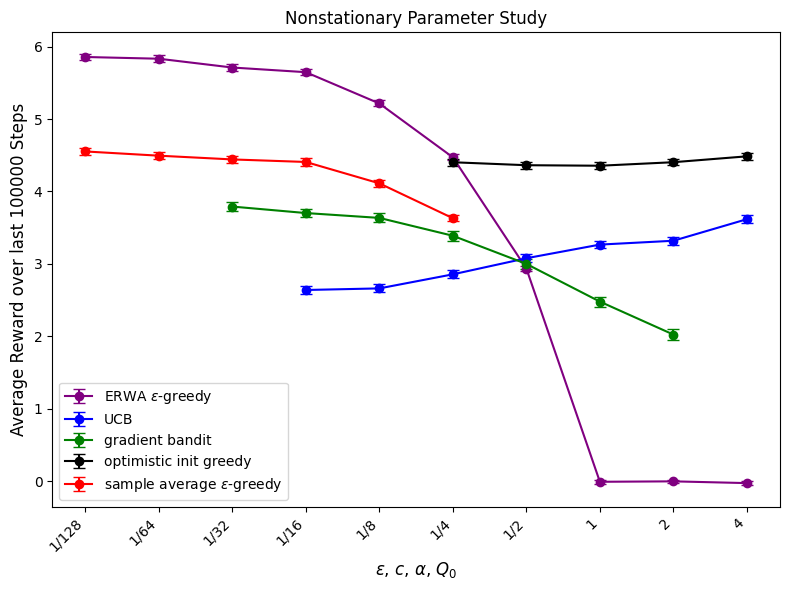

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))

# Unique algos for legend and colors
algos = result_stats['algo_name'].unique()

# Plot each algo separately
for algo in algos:
    subdf = result_stats[result_stats['algo_name'] == algo]
    x = subdf['hyperparameter_value_exp']
    y = subdf['mean']
    yerr = subdf['standard_error']
    
    ax.errorbar(
        x, y, yerr=yerr,
        label=algo,
        color=COLOR_MAP[algo],
        fmt='o-', capsize=4
    )

# Set x-axis ticks as powers of two from 2^-7 to 2^2
tick_exps = np.arange(-7, 3)
tick_labels = [f"1/{2**-exp}" if exp < 0 else f"{2**exp}" for exp in tick_exps]
ax.set_xticks(tick_exps)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

# Compose xlabel with hyperparameter names, colored by algo_name
xlabel_text = ", ".join(DISPLAY_NAMES)

ax.set_xlabel(xlabel_text, fontsize=12)
ax.set_ylabel("Average Reward over last 100000 Steps", fontsize=12)

ax.legend()

plt.title("Nonstationary Parameter Study")

plt.tight_layout()
plt.show()